# Capstone project: Data tells where to build new hotels in Berlin, Germany

### Import neccessary libraries to run the project

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### This cell stored the Foursquare API credential. Due to confidentiality, the information has been removed

In [21]:
CLIENT_ID = '*****************' # my Foursquare ID
CLIENT_SECRET = '**************' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: *****************
CLIENT_SECRET:**************


### Data collection from Foursquare, using Foursquare API

The data required to solve the problem is the Foursquare data for interesting places in Berlin, Germany. We first choose the city center as our starting point. From this point, we will explore venues within the radius as 10,000m 

In [3]:
#Getting the location data of Berlin 

address = 'Berlin, Germany'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

52.5170365 13.3888599


In [4]:
# Define function to get category name
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
# We explore the area within the radius of 10 km from Berlin city center
radius = 10000 # 10km from city center
VERSION = 20190101
LIMIT=50
offset=0

We use Foursquare API to get the venues data within the radius as 10,000m from Berlin city center. As tourists were those who visited places in Berlin and provide ratings, we will focus on these places. We will pass query=tourist into the URL to filter these values which will helpful for other tourists. 

In [6]:
# Create a list storing result pages, each page containing 50 venues (maximum number of venus in a response)
explore_data_pages = []
no_of_venues = 0
max_pages = 100

print('Explore venues within {} km from {} city center'.format(radius/1000,address))
for i in range(0,max_pages):
    offset = i * 50
    print('Loading page {}/{}'.format(i+1, max_pages))
    # Using query=tourist 
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&offset={}&query=tourist'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, offset)
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    no_of_venues += len(items)
    
    # Check if all venues within the radius have been returned
    if len(items) == 0:
        print('No more venues')
        break
        
    print('{} venues discovered'.format(no_of_venues))
    
    dataframe = json_normalize(items) # flatten JSON
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    # clean columns
    dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
    explore_data_pages.append(dataframe_filtered)

Explore venues within 10.0 km from Berlin, Germany city center
Loading page 1/100
50 venues discovered
Loading page 2/100
100 venues discovered
Loading page 3/100
150 venues discovered
Loading page 4/100
200 venues discovered
Loading page 5/100
215 venues discovered
Loading page 6/100
No more venues


In [14]:
explore_df = pd.concat(explore_data_pages, ignore_index=True, axis=0)
explore_df.to_excel('explore_df.xlsx')

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [9]:
explore_df.head()

,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state
0,Behrenstr. 55-57,Opera House,DE,Berlin,Deutschland,NaN,188,"[Behrenstr. 55-57, 10117 Berlin, Deutschland]",4adcda8af964a520bd4921e3,"[{'label': 'display', 'lat': 52.51596828902978...",52.515968,13.386701,Komische Oper,Unter den Linden,10117,Berlin
1,Gendarmenmarkt,Concert Hall,DE,Berlin,Deutschland,Charlottenstr.,429,"[Gendarmenmarkt (Charlottenstr.), 10117 Berlin...",4adcda7cf964a520584721e3,"[{'label': 'display', 'lat': 52.513652, 'lng':...",52.513652,13.391911,Konzerthaus Berlin,NaN,10117,Berlin
2,Markgrafenstr.,Plaza,DE,Berlin,Deutschland,Mohrenstr.,466,"[Markgrafenstr. (Mohrenstr.), 10117 Berlin, De...",4adcda7df964a5206a4721e3,"[{'label': 'display', 'lat': 52.51357005399756...",52.513570,13.392720,Gendarmenmarkt,NaN,10117,Berlin
3,Bebelplatz,Plaza,DE,Berlin,Deutschland,Unter den Linden,342,"[Bebelplatz (Unter den Linden), 10117 Berlin, ...",4adcda7df964a520ab4721e3,"[{'label': 'display', 'lat': 52.51653012045096...",52.516530,13.393847,Bebelplatz,NaN,10117,Berlin
4,Am Festungsgraben 1,Theater,DE,Berlin,Deutschland,NaN,481,"[Am Festungsgraben 1, 10117 Berlin, Deutschland]",4adcda89f964a520954921e3,"[{'label': 'display', 'lat': 52.51894077519612...",52.518941,13.395245,Maxim Gorki Theater,NaN,10117,Berlin


Because we use the Foursquare API sandbox account, there is no rating of the place in the returned dataset yet. In order to obtain the ratings, we need to pass the ID of each location to URL, and call the Foursquare API. Since Foursquare provides also the number of likes for each venue, we collect this data in the call, too. 

In [10]:
# Get venue ratings 
venue_id = '4adcda09f964a520e83321e3'#Cathédrale Notre-Dame de Paris
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id,CLIENT_ID, CLIENT_SECRET, VERSION)
print(url)
results = requests.get(url).json()

https://api.foursquare.com/v2/venues/4adcda09f964a520e83321e3?client_id=GNCGGWITROW2Q2PT444JNZS0P1AU0QGURW0HAD3L511F4YHL&client_secret=UAKOV4KC5FPZ024DB4EHIJWIDBBH5GLTATULKCLGYU4PPWHH&v=20190101


In [11]:
results

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '5cd5fc2b9fb6b756b10e2797'},
 'response': {}}

In [12]:
def get_venue_likes_and_rating(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id,CLIENT_ID, 
                                                                                              CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    try:
        likes = results['response']['venue']['likes']['count']
    except:
        likes = np.nan
        #print('Venue {} has no like info'.format(venue_id))
    
    try:    
        rating = results['response']['venue']['rating']
    except:
        rating = np.nan
        #print('Venue {} has no rating info'.format(venue_id))
        
    return (likes,rating)

In [15]:
#Initiate values for 2 columns "no_of_likes" and "rating", default null
explore_df['no_of_likes'],explore_df['rating'] = (np.nan,np.nan)

In [16]:
#Loop through each venue, get number of likes and rating for each venue
venue_count = explore_df.shape[0]

In [17]:
# Key error = 78 means the limit calls for a day has reached, so need to wait until the next day to run.
from ipywidgets import IntProgress #library to display progress bar
from IPython.display import display

print('Loading venue')

f = IntProgress(min=0, max=venue_count) # instantiate the bar
display(f) # display the bar

row_no = 0
while row_no < venue_count:
    venue_id = explore_df.at[row_no,'id']
    likes_rating = get_venue_likes_and_rating(venue_id)
    explore_df.at[row_no,'no_of_likes'] = likes_rating[0]
    explore_df.at[row_no,'rating'] = likes_rating[1]
    f.value += 1 # signal to increment the progress bar
    f.description = '{}/{}'.format(row_no, venue_count)
    row_no += 1

Loading venue


IntProgress(value=0, max=215)

### Data exploratory analysis 

In this section, we will plot the dataset into appropriate diagram to have the overview about our data. We decide to use Histogram and Boxplot to observe the distribution of our dataset.

In [20]:
#Plot the histogram for number of likes and rating
hist = explore_df[['no_of_likes','rating']].hist(bins=20, figsize = (10,3))
hist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C6B10F0>,
      dtype=object)

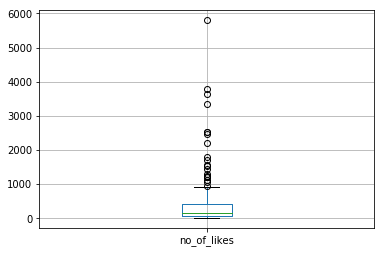

In [34]:
#Plot the box plot for number of likes
likes_df = explore_df[['no_of_likes']]
boxplot = likes_df.boxplot()

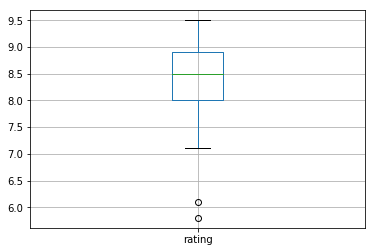

In [35]:
#Plot the box plot for number of rating
rates_df = explore_df[['rating']]
boxplot = rates_df.boxplot()

#### Drop places where rating is less than 7.5

Per observation, there are several outliers in the box plot for rating, and as we believe that those places with rating <7.5 would not be interesting to other people, then we will drop them from our dataset

In [40]:
# Get names of indexes for which column rating has value less than 7.5
indexNames = explore_df[explore_df['rating'] < 7.5 ].index
 
# Delete these row indexes from dataFrame
explore_df.drop(indexNames , inplace=True)

In [41]:
explore_df_clustering = explore_df.drop(['address', 'categories','cc','city','country','crossStreet','distance','formattedAddress','id','labeledLatLngs','name','neighborhood','postalCode','state','no_of_likes','rating'],1)

#### Prepare dataset to run visualize data on map

In [42]:
explore_df_clustering.head()

,lat,lng
0,52.515968,13.386701
1,52.513652,13.391911
2,52.513570,13.392720
3,52.516530,13.393847
4,52.518941,13.395245


In [23]:
results

{'meta': {'code': 200, 'requestId': '5cd337f1f594df21c097a754'},
 'response': {'venue': {'id': '4adcda09f964a520e83321e3',
   'name': 'Cathédrale Notre-Dame de Paris',
   'contact': {'phone': '+33142345610',
    'formattedPhone': '+33 1 42 34 56 10',
    'twitter': 'notredame2paris',
    'facebook': '100572883398118',
    'facebookUsername': 'cathedrale.notredamedeparis',
    'facebookName': 'Cathédrale Notre-Dame de Paris'},
   'location': {'address': '6 place du parvis Notre-Dame',
    'crossStreet': 'Place Jean-Paul II',
    'lat': 48.85312443201169,
    'lng': 2.3495614528656006,
    'labeledLatLngs': [{'label': 'display',
      'lat': 48.85312443201169,
      'lng': 2.3495614528656006}],
    'postalCode': '75004',
    'cc': 'FR',
    'city': 'Paris',
    'state': 'Île-de-France',
    'country': 'France',
    'formattedAddress': ['6 place du parvis Notre-Dame (Place Jean-Paul II)',
     '75004 Paris',
     'France']},
   'canonicalUrl': 'https://foursquare.com/v/cath%C3%A9drale-not

In [97]:
explore_df.to_excel('explore_df_withrating.xlsx')

We will plot the all the interesting places in our dataset into the map to see how the places are locating in the city 

In [43]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the city center
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='City Center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the explored venues as blue circle markers
for lat, lng, label in zip(explore_df.lat, explore_df.lng, explore_df.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        #popup=label,
        popup='',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### Running k-means clustering with k = 5

We start the first experiment with k = 5, as we make the assumption that a city can be split into 5 main areas: North, East, South, West and center

In [62]:
# Use kmeans from sklearn
k_means = KMeans(init="k-means++", n_clusters=5, n_init=12)
k_means.fit(explore_df_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=12, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [63]:
#Adding the cluster labels into dataset. 
explore_df.insert(0,'Cluster Labels',k_means.labels_)
explore_df.head()

,Cluster Labels,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state,no_of_likes,rating
0,0,Behrenstr. 55-57,Opera House,DE,Berlin,Deutschland,NaN,188,"['Behrenstr. 55-57', '10117 Berlin', 'Deutschl...",4adcda8af964a520bd4921e3,"[{'label': 'display', 'lat': 52.51596828902978...",52.515968,13.386701,Komische Oper,Unter den Linden,10117.0,Berlin,182,8.7
1,0,Gendarmenmarkt,Concert Hall,DE,Berlin,Deutschland,Charlottenstr.,429,"['Gendarmenmarkt (Charlottenstr.)', '10117 Ber...",4adcda7cf964a520584721e3,"[{'label': 'display', 'lat': 52.513652, 'lng':...",52.513652,13.391911,Konzerthaus Berlin,NaN,10117.0,Berlin,327,9.2
2,0,Markgrafenstr.,Plaza,DE,Berlin,Deutschland,Mohrenstr.,466,"['Markgrafenstr. (Mohrenstr.)', '10117 Berlin'...",4adcda7df964a5206a4721e3,"[{'label': 'display', 'lat': 52.51357005399756...",52.513570,13.392720,Gendarmenmarkt,NaN,10117.0,Berlin,1293,9.4
3,0,Bebelplatz,Plaza,DE,Berlin,Deutschland,Unter den Linden,342,"['Bebelplatz (Unter den Linden)', '10117 Berli...",4adcda7df964a520ab4721e3,"[{'label': 'display', 'lat': 52.51653012045096...",52.516530,13.393847,Bebelplatz,NaN,10117.0,Berlin,176,8.8
4,4,Am Festungsgraben 1,Theater,DE,Berlin,Deutschland,NaN,481,"['Am Festungsgraben 1', '10117 Berlin', 'Deuts...",4adcda89f964a520954921e3,"[{'label': 'display', 'lat': 52.51894077519612...",52.518941,13.395245,Maxim Gorki Theater,NaN,10117.0,Berlin,134,9.1


### Visualize the resulting clusters

In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters=5
# add a yellow circle marker to represent the city center
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='yellow',
    popup='City Center',
    fill = True,
    fill_color = 'yellow',
    fill_opacity = 0.6
).add_to(map_clusters)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(explore_df['lat'], explore_df['lng'], explore_df['name'], explore_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [68]:
# Identify the centroids of all clusters
temp = k_means.cluster_centers_
temp

array([[52.50545502, 13.38396015],
       [52.47265052, 13.28971823],
       [52.51058923, 13.33291563],
       [52.50784656, 13.46330149],
       [52.52842109, 13.40720669]])

In [69]:
# Add centroids into the maps. 
for i in temp:
    # add a marker to represent the centroid
    folium.Marker(
    [i[0], i[1]],
    popup='Recommended place to build up hotels',
    ).add_to(map_clusters)
map_clusters

### Model evaluation using Elbow method

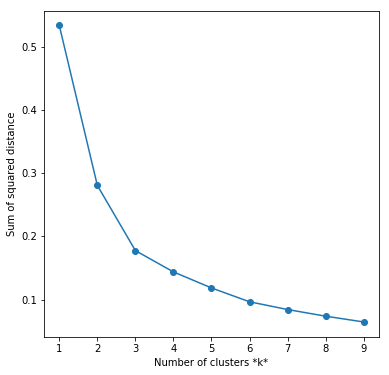

In [70]:
# Run the Kmeans algorithm and get the index of data points clusters
import matplotlib.pyplot as plt
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(explore_df_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.show()

### Re-run the model with k = 3 

From the graph displayed, we can see the value k =5 selected earlier indeed is not the best choice for k. It is still pretty hard to figure out the good number of clusters to use because the curve is monotonically decreasing, but we can choose k=3 where we still can see a significant change in the line chart from k =2 to k =3. 

In [94]:
# Create a new kmeans instance, and run with k = 3. Afterwards, adding the Cluster Label_3 into dataset.
k_means = KMeans(init="k-means++", n_clusters=3, n_init=12)
k_means.fit(explore_df_clustering)
explore_df.insert(0,'Cluster Labels_3',k_means.labels_)
explore_df.head()

,Cluster Labels_3,Cluster Labels,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state,no_of_likes,rating
0,1,0,Behrenstr. 55-57,Opera House,DE,Berlin,Deutschland,NaN,188,"['Behrenstr. 55-57', '10117 Berlin', 'Deutschl...",4adcda8af964a520bd4921e3,"[{'label': 'display', 'lat': 52.51596828902978...",52.515968,13.386701,Komische Oper,Unter den Linden,10117.0,Berlin,182.0,8.7
1,1,0,Gendarmenmarkt,Concert Hall,DE,Berlin,Deutschland,Charlottenstr.,429,"['Gendarmenmarkt (Charlottenstr.)', '10117 Ber...",4adcda7cf964a520584721e3,"[{'label': 'display', 'lat': 52.513652, 'lng':...",52.513652,13.391911,Konzerthaus Berlin,NaN,10117.0,Berlin,328.0,9.2
2,1,0,Markgrafenstr.,Plaza,DE,Berlin,Deutschland,Mohrenstr.,466,"['Markgrafenstr. (Mohrenstr.)', '10117 Berlin'...",4adcda7df964a5206a4721e3,"[{'label': 'display', 'lat': 52.51357005399756...",52.513570,13.392720,Gendarmenmarkt,NaN,10117.0,Berlin,1295.0,9.4
3,1,0,Bebelplatz,Plaza,DE,Berlin,Deutschland,Unter den Linden,342,"['Bebelplatz (Unter den Linden)', '10117 Berli...",4adcda7df964a520ab4721e3,"[{'label': 'display', 'lat': 52.51653012045096...",52.516530,13.393847,Bebelplatz,NaN,10117.0,Berlin,176.0,8.8
4,1,4,Am Festungsgraben 1,Theater,DE,Berlin,Deutschland,NaN,481,"['Am Festungsgraben 1', '10117 Berlin', 'Deuts...",4adcda89f964a520954921e3,"[{'label': 'display', 'lat': 52.51894077519612...",52.518941,13.395245,Maxim Gorki Theater,NaN,10117.0,Berlin,134.0,9.0


### Visualize the resulting clusters

In [72]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters=3
# add a yellow circle marker to represent the city center
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='yellow',
    popup='City Center',
    fill = True,
    fill_color = 'yellow',
    fill_opacity = 0.6
).add_to(map_clusters)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(explore_df['lat'], explore_df['lng'], explore_df['name'], explore_df['Cluster Labels_3']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

Finally, we get the centroids of these clusters, and plot them on the map . They are the places where we recommend to build up hotels in Berlin

In [73]:
# Identify the centroids of all clusters
temp = k_means.cluster_centers_
temp

array([[52.49443318, 13.32011556],
       [52.51863586, 13.39019408],
       [52.50794037, 13.44887055]])

In [74]:
# Add centroids into the maps. They are the places we recommend to build the hotel chains
for i in temp:
    # add a marker to represent the centroid
    folium.Marker(
    [i[0], i[1]],
    popup='Recommended place to build up hotels',
    ).add_to(map_clusters)
map_clusters